In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 

%reload_ext autoreload
%aimport Funcs
%aimport fluid_flow
%aimport parameters
from Funcs import advance_adv_diff_RK3, advance_adv_diff_RK4
from fluid_flow import advance_fluid_flow, set_boundary, dt_fluid_flow
from pathlib import Path
from parameters import * # <-- dangerous; make sure to put only global constants in that file
N = 200
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
dt = dt_fluid_flow(dx, Fo=0.3)
dt

2.02015100628772e-06

# Visulizing FluidFlow

1. Simulation

In [2]:
from Funcs import metric_L0, metric_RMS
from math import sin, pi, exp
from poisson_solver import get_atol
import time
dt = dt_fluid_flow(dx, Fo=0.3)
u0 = np.zeros((N,N))
v0 = np.copy(u0)
u0,v0 = set_boundary(u0,v0,Ns_c, Nc_lw)
u, v = np.copy(u0), np.copy(v0)
amax     = 1e-4 # initial value for atol at t=0
amin     = 1e-8 # value at tmax
tmax     = 0.01 # atol = amax for t > tmax
w = 2 / (1 + sin(pi/N))
N_loop = 3600
t = 0.015
dt_measure = t / N_loop
Nt = int(dt_measure / dt)
n_conv_check = int(np.round(8.9e-5/dt))
Nt0=1
u, v, P = advance_fluid_flow(Nt0, u, v, advance_adv_diff_RK3, dt)[:3]
t0 = time.time()
# convergence analysis:
U=[u]
V=[v]
Pr=[P]
for i in range(N_loop):
    
    t = i * dt * Nt + dt * Nt0 
    atol = get_atol(t, amin, amax, tmax)    
    u, v, P = advance_fluid_flow(Nt, u, v, advance_adv_diff_RK3, dt, w=w, atol=atol, P=P, n_conv_check=n_conv_check)[:3]
    if i==3000:
        plt.imshow(u.T**2+v.T**2)
    U .append(u.copy())
    V .append(v.copy())
    Pr.append(P.copy())
print('CPU time [s]: ', time.time() - t0)
plt.show()

2. Data Saving

In [8]:
U=np.array(U)
V=np.array(V)
Pr=np.array(Pr)
if True:
    p = Path('data/vel_field/data_cube/') / 'UVP_cube_N_{}_Leap_{}_dt_{}.npy'.format(N,N_loop,dt)
    np.save(p, np.array([U,V,P]))
if False:
    p = Path('data/vel_field/data_cube/') / 'UVP_cube_N_{}_Leap_{}_dt_{}.npy'.format(N,N_loop,dt)
    U,V,P=np.load(p)
dt


C:\Users\hp\AppData\Local\Temp\ipykernel_4552\4121164881.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(p, np.array([U,V,P]))


2.02015100628772e-06

3. Visulization

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
def update(frame):
    # ln[1].set_data(V[frame].T**2+U[frame].T**2)
    N_leap=1
    ln[0].set_UVC(U_reduced[frame*N_leap].T, V_reduced[frame*N_leap].T)
    ln[1].set_array(V[frame*N_leap].T**2+U[frame*N_leap].T**2)
    ln[2].set_array(Pr[frame*N_leap].T)
    ln3.set_clim(vmin=0,vmax=np.max(Pr[frame*N_leap]))
    ln[3].set_text('${:05.2f}ms$'.format(frame*N_leap*dt_measure*10**3))
    if frame*N_leap%20==0:  
        print(frame*N_leap,frame*N_leap%100) 
    #  cbar2 = fig.colorbar(ln3, cax=cax)
    return ln
# Ut=U.copy()
# Vt=V.copy()
# Pt=Pr.copy()
def reduce_matrix (Mat, a=2):
    Mat_2 = np.zeros((int(Mat.shape[0]/a),int(Mat.shape[1]/a)))
    # print(Mat_2.shape)
    for i in range(int(len(Mat)/a)):
        for j in range(int(len(Mat)/a)):        
            for k in range(a):
                for l in range(a):
                    # print(  int(len(Mat)/a),i,j,k,l)
                    Mat_2[i,j]+= Mat[i*a+k,j*a+l]
    Mat_2/=a**2
    return Mat_2
i = -1
print(U.shape)
plt.figure()
plt.imshow(U[i].T**2+V[i].T**2)
plt.show()
plt.figure()
plt.imshow(reduce_matrix (U[i].T**2+V[i].T**2,10))
plt.show()

NameError: name 'U' is not defined

In [ ]:
U_reduced = np.array([reduce_matrix(U [i],4) for i in range(len(U))])
V_reduced = np.array([reduce_matrix(V [i],4) for i in range(len(U))])
P_reduced = np.array([reduce_matrix(Pr[i],4) for i in range(len(U))])

fig, (ax,ax2) = plt.subplots(1,2,figsize=(32,16))
fontsize=28
ln1  = ax.quiver(np.arange(0,1,step=1/len(U_reduced[0]))*(U[0].shape[0]+1),
                 np.arange(0,1,step=1/len(U_reduced[0]))*(U[0].shape[1]+1),
                 U_reduced[0].T   ,
                 V_reduced[0].T   ,scale=20,zorder=2)

x, y = np.meshgrid(np.arange(0, 1, 1/U[0].shape[0]), 
                   np.arange(0, 1, 1/U[0].shape[1]))

ln2  = ax.pcolormesh(U[0].T**2+V[0].T**2,
                     zorder=1,vmin=0,vmax=1.75,cmap='rainbow')
ln3  = ax2.pcolormesh(Pr[0].T           ,zorder=1,                 cmap='rainbow')
txt = ax.text(100,100,'$0\\mu s$',zorder=3,fontsize = fontsize*2)
ax .set_xticklabels(ax .get_xticks()/N,fontsize=fontsize)
ax .set_yticklabels(ax .get_yticks()/N,fontsize=fontsize)
ax2.set_xticklabels(ax2.get_xticks()/N,fontsize=fontsize)
ax2.set_yticklabels(ax2.get_yticks()/N,fontsize=fontsize)

cbar  = fig.colorbar(ln2,ax=ax )
cbar.set_label(r"Energy $u^2+v^2 [J/\rho]$",fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
div = make_axes_locatable(ax2)
cax = div.append_axes('right', '5%', '5%')
cbar2 = fig.colorbar(ln3, cax=cax)
cbar2.set_label(r"Pressure $[Pa]$",fontsize=fontsize)
cbar2.ax.tick_params(labelsize=fontsize)

ln = [ln1,ln2,ln3,txt]

ax .set_title("energie and direction evolution \nof the velocity until stability",fontsize = fontsize)
ax .set_ylabel('y-direction (mm)',fontsize = fontsize)
ax .set_xlabel('x-direction (mm)',fontsize = fontsize)
ax2.set_title("pressure evolution of the velocity\n until stability",fontsize = fontsize)
ax2.set_ylabel('y-direction (mm)',fontsize = fontsize)
ax2.set_xlabel('x-direction (mm)',fontsize = fontsize)
fig.suptitle('Fluid Flow Simulation {}x{}\n(Velocity Evolution)'.format(N,N),fontsize = 1.5*fontsize)
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\hp\Documents\ffmpeg-2021-10-18-git-d04c005021-full_build\bin\ffmpeg.exe"
writer = animation.writers['ffmpeg']
writer = writer(fps=60, metadata=dict(artist='Slimane MZERGUAT'), bitrate=1800*2)
ani = FuncAnimation(fig, update, blit=True, frames=int(len(U)),interval=50,repeat=False)#int(len(U)/50)
ani.save("res.mp4", writer=writer)
plt.show()


In [11]:
x = np.arange(0,5)
x[np.arange(0,5,step=2)]

array([0, 2, 4])

# Pre-combustion

In [3]:
%matplotlib widget
# %matplotlib notebook doesn't work on vscode

import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from species_transport import set_BCs, set_Temp_BC, evolve_species


In [5]:
N = 50
M=N
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
dt = dt_fluid_flow(dx, Fo=0.3)
datap = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
u,v,_ = np.load(datap)
# initial setup of the species distribution
CH4, O2, N2, H2O, CO2, T = np.zeros((6,N,M))
O2[:] = .233
N2[:] = .767
T[:] = 300
Y = np.array([CH4, O2, N2, CO2, H2O])
t = 0.045
N_loop = 36
t_measure = t/N_loop 
Nt = int(t_measure/dt)

In [6]:
#for pre-combustion
def update(frame):
    global Y,T
    # ln[1].set_data(V[frame].T**2+U[frame].T**2)
    N_leap=1
    for i in range(N_leap):
        Y,T = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=False, evolve_T=False)
    for i in range(5):
        im[i].set_array(Y[i].T)
        im[i].set_clim(vmin=0,vmax=(np.max(Y[i].T) if i != 4 else 1 ) if np.max(Y[i].T)!= 0 else 1) 
    im[5].set_array(T.T)
    im[5].set_clim(vmin=0,vmax=np.max(T.T))
    im[-1].set_text('Pre-combustion Simulation {}x{}\n(Species Evolution) \n time={:5.2f}ms'.format(N,N,t_measure*frame*N_leap*1e3))
    if frame*N_leap%20==0:  
        print("frame:{:04d}".format(frame*N_leap)) 
    return im

NameError: name 'Y' is not defined

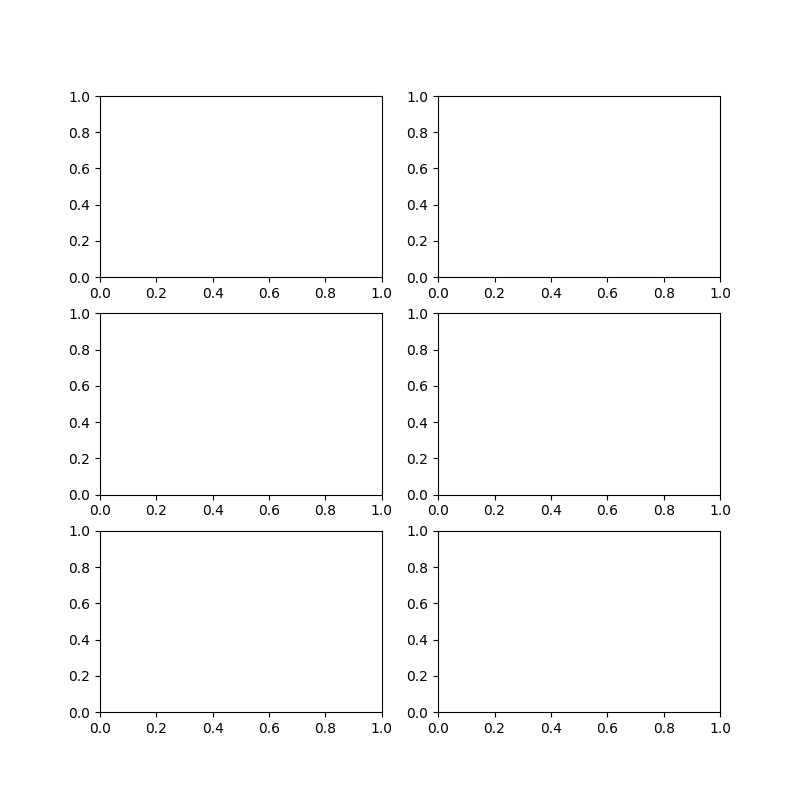

In [4]:
from species_transport import species_names_2
fig, axis = plt.subplots(3,2,figsize=(16/2,32/4))
axis = axis.flatten()
im = [0 for i in range(2*len(species_names_2)+2)]
fontsize = 10
for k in range(len(axis)):
    #plotting first in stances
    if k == len(species_names_2):
        cmap = 'hot'
        dat = T.T
        title = 'Temperature' # '$T$ [K]'
        vmin,vmax=0,T.max()
        cmap = 'hot'
    else :
        dat = Y[k].T
        title = 'Y_{' + species_names_2[k] + '}'
        title = r'${}$'.format(title)
        vmin, vmax=0,1
        cmap = 'seismic'
    im[k] = axis[k].imshow(dat, cmap=cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, extent=(0,1,0,1))
    if k==len(species_names_2):
        im[k+len(species_names_2)+1] =fig.colorbar(im[k], ax=axis[k])
    else:
        im[k+len(species_names_2)+1] =fig.colorbar(im[k], ax=axis[k])
    
    #organizing the graphs
    axis[k].set_title(
        '$Y_{{ {} }}$'.format(species_names_2[k]) if k!= len(species_names_2) else "Temperature [K]",fontsize=fontsize*1.3)
    # axis[k].set_xticklabels(ax .get_xticks(),fontsize=fontsize)
    # axis[k].set_yticklabels(ax .get_yticks(),fontsize=fontsize)
    axis[k].tick_params(axis='y', labelsize=fontsize )
    axis[k].tick_params(axis='x', labelsize=fontsize )
    im[k+len(species_names_2)+1].ax.tick_params(labelsize=fontsize)
    if k ==4 or k==5:
        axis[k].set_xlabel("x-direction",fontsize=fontsize)
    if k in [0,2,4]:
        axis[k].set_ylabel("y-direction",fontsize=fontsize)

fig.legend()
suptitle = fig.suptitle('Pre-combustion Simulation {}x{}\n(Species Evolution) \n time={:5.2f}ms'.format(N,N,t_measure*N_loop*1e3),fontsize = 1.5*fontsize)
im.append(suptitle)
fig.tight_layout()
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\hp\Documents\ffmpeg-2021-10-18-git-d04c005021-full_build\bin\ffmpeg.exe"
writer = animation.writers['ffmpeg']
writer = writer(fps=60, metadata=dict(artist='Slimane MZERGUAT'), bitrate=1800*2)
ani = FuncAnimation(fig, update, blit=True, frames=N_loop,interval=50,repeat=False)
ani.save("Species evolution.mp4", writer=writer)
plt.show()

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from visualization import plot_species_overview, plot_velocity_vector_field
from species_transport import evolve_species, set_up_T, species_names
from Funcs import metric_L0, metric_RMS
from species_transport import get_dt_chem
dt_chem = get_dt_chem(N)
t = 0.030
t_measure = t/N_loop 
Nt = int(t_measure/dt)
print(Nt,dt,dt_chem)

# load the velocity field:
data_vel = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N,N)
u,v,_ = np.load(data_vel)

# load the species and temperature fields as computed in the pre-combustion phase:
data_sp = Path('data/species/test0') / 'N{}.npy'.format(N,N)
species_data = np.load(data_sp)
Y = species_data[:-1,:, :]
T = species_data[-1, :, :]
T = set_up_T(N,N, dy, smooth=False)
M=N
# min_M,max_M=int(M*0.35),int(M*0.65) + 1
# min_N,max_N=int(N*0),int(N*0.10) + 1#0,N
# T = np.ones((N,M))*300
# T[min_N:max_N,min_M:max_M]=1000
plt.imshow(T.T)
def update(frame):
    global Y,T
    # ln[1].set_data(V[frame].T**2+U[frame].T**2)
    N_leap=1
    for i in range(N_leap):
        Y, _ = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, dt_chem=dt_chem, evolve_T=False)
    for i in range(5):
        im[i].set_array(Y[i].T)
        im[i].set_clim(vmin=0,vmax=np.max(Y[i].T)) 
    im[5].set_array(T.T)
    im[5].set_clim(vmin=0,vmax=np.max(T.T))
    im[-1].set_text('Ignition Simulation {}x{}\n(Combustion with Fixed Temperature) \n time={:5.2f}ms'.format(N,N,t_measure*frame*N_leap*1e3))
    if frame*N_leap%1==0:  
        print("frame:{:04d}".format(frame*N_leap)) 
    return im

NameError: name 'N_loop' is not defined

No handles with labels found to put in legend.


frame:0000
frame:0000
frame:0020
frame:0040


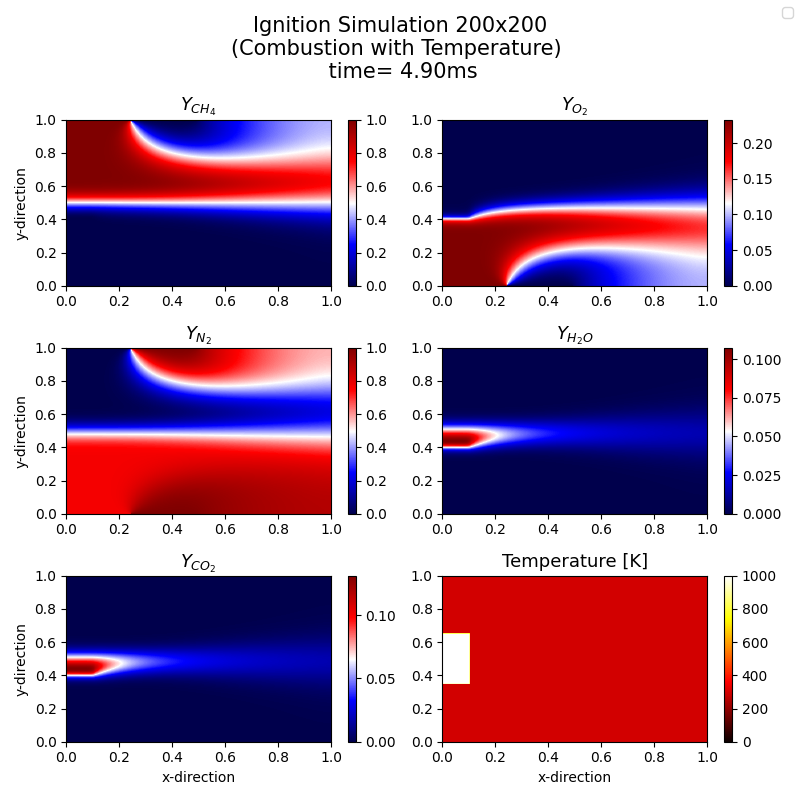

In [7]:
from species_transport import species_names_2
fig, axis = plt.subplots(3,2,figsize=(16/2,32/4))
axis = axis.flatten()
im = [0 for i in range(2*len(species_names_2)+2)]
fontsize = 10
for k in range(len(axis)):
    #plotting first in stances
    if k == len(species_names_2):
        cmap = 'hot'
        dat = T.T
        title = 'Temperature' # '$T$ [K]'
        vmin,vmax=0,T.max()
        cmap = 'hot'
    else :
        dat = Y[k].T
        title = 'Y_{' + species_names_2[k] + '}'
        title = r'${}$'.format(title)
        vmin, vmax=0,1
        cmap = 'seismic'
    im[k] = axis[k].imshow(dat, cmap=cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, extent=(0,1,0,1))
    if k==len(species_names_2):
        im[k+len(species_names_2)+1] =fig.colorbar(im[k], ax=axis[k])
    else:
        im[k+len(species_names_2)+1] =fig.colorbar(im[k], ax=axis[k])
    
    #organizing the graphs
    axis[k].set_title(
        '$Y_{{ {} }}$'.format(species_names_2[k]) if k!= len(species_names_2) else "Temperature [K]",fontsize=fontsize*1.3)
    # axis[k].set_xticklabels(ax .get_xticks(),fontsize=fontsize)
    # axis[k].set_yticklabels(ax .get_yticks(),fontsize=fontsize)
    axis[k].tick_params(axis='y', labelsize=fontsize )
    axis[k].tick_params(axis='x', labelsize=fontsize )
    im[k+len(species_names_2)+1].ax.tick_params(labelsize=fontsize)
    if k ==4 or k==5:
        axis[k].set_xlabel("x-direction",fontsize=fontsize)
    if k in [0,2,4]:
        axis[k].set_ylabel("y-direction",fontsize=fontsize)

fig.legend()
suptitle = fig.suptitle('Ignition Simulation {}x{}\n(Combustion with Fixed Temperature) \n time={:5.2f}ms'.format(N,N,0),fontsize = 1.5*fontsize)
im.append(suptitle)
fig.tight_layout()
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\hp\Documents\ffmpeg-2021-10-18-git-d04c005021-full_build\bin\ffmpeg.exe"
writer = animation.writers['ffmpeg']
writer = writer(fps=60, metadata=dict(artist='Slimane MZERGUAT'), bitrate=1800*2)
ani = FuncAnimation(fig, update, blit=True, frames=N_loop,interval=50,repeat=False)
ani.save("Ignition.mp4", writer=writer)
plt.show()

# Combustion

3.3669183438128666e-07
198 1.01007550314386e-06 3.0


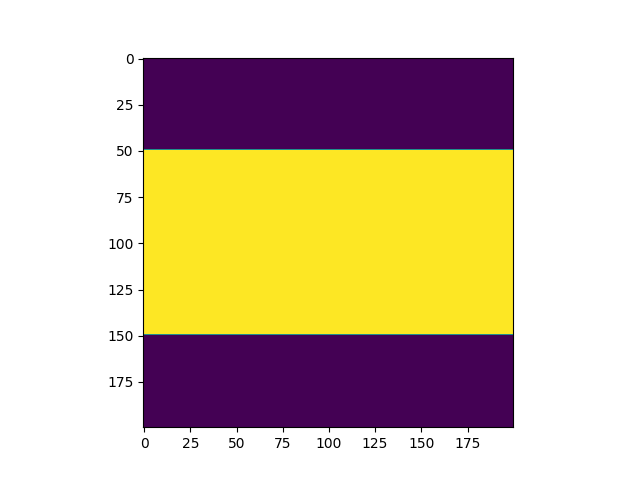

In [30]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from visualization import plot_species_overview, plot_velocity_vector_field
from species_transport import evolve_species, set_up_T, species_names
from Funcs import metric_L0, metric_RMS
from species_transport import get_dt_chem
import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from visualization import plot_species_overview, plot_velocity_vector_field
from species_transport import evolve_species
from species_transport import compute_Y_combustion, save_Y_T, load_Y_T, get_dt_chem
import time

# N = 200
# dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
# dt = dt_fluid_flow(dx, Fo=0.3)
# dt
# dt_chem = get_dt_chem(N)
# t = 0.001
# N_loop=50
# t_measure = t/N_loop 
# Nt = int(t_measure/dt)
# print(Nt,dt,dt/dt_chem)
# data_vel = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N,N)
# u,v,_ = np.load(data_vel)
# data_sp = Path('data/species/test0') / 'N{}.npy'.format(N,N)
# species_data = np.load(data_sp)
# Y = species_data[:-1,:, :]
# T = species_data[-1, :, :]
# T = set_up_T(N,N, dy, smooth=False)
# M=N

N = 200
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
dt = dt_fluid_flow(dx, Fo=0.3 * 0.5)
data_vel = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
u,v,_ = np.load(data_vel)
data_sp = Path('data/species_ignited/test0') / 'N{}.npy'.format(N)
Y,T = load_Y_T(data_sp)
t = 0.005
N_loop=50
t_measure = t/N_loop 
Nt = int(t_measure/dt)
dt_chem = get_dt_chem(N)
print(dt_chem)
print(Nt,dt,dt/dt_chem)

plt.imshow(T.T)
def update(frame):
    global Y,T
    # ln[1].set_data(V[frame].T**2+U[frame].T**2)
    N_leap=1
    for i in range(N_leap):
        Y, _ = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, dt_chem=(dt_chem), evolve_T=True)
    for i in range(5):
        im[i].set_array(Y[i].T)
        im[i].set_clim(vmin=0,vmax=np.max(Y[i].T)) 
    im[5].set_array(T.T)
    im[5].set_clim(vmin=0,vmax=np.max(T.T))
    im[-1].set_text('Combustion Simulation {}x{}\n(CCombustion with dynamic temperature) \n time={:5.2f}ms'.format(N,N,t_measure*frame*N_leap*1e3))
    if frame*N_leap%1==0:  
        print("frame:{:04d}".format(frame*N_leap)) 
    return im

No handles with labels found to put in legend.


frame:0000
frame:0000
frame:0001
frame:0002
frame:0003
frame:0004
frame:0005
frame:0006
frame:0007
frame:0008
frame:0009


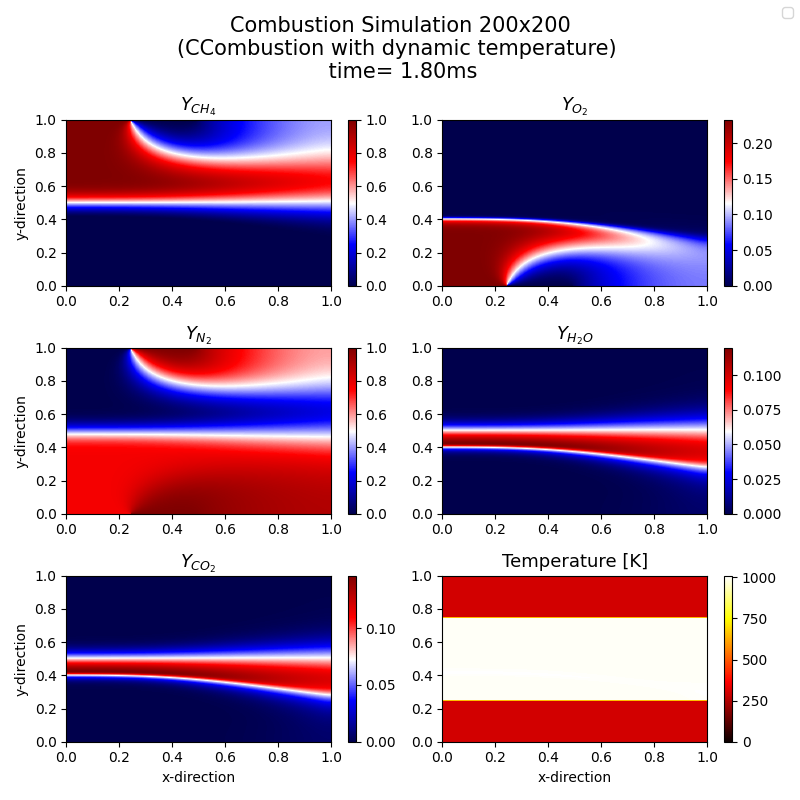

In [31]:
from species_transport import species_names_2
fig, axis = plt.subplots(3,2,figsize=(16/2,32/4))
axis = axis.flatten()
im = [0 for i in range(2*len(species_names_2)+2)]
fontsize = 10
for k in range(len(axis)):
    #plotting first in stances
    if k == len(species_names_2):
        cmap = 'hot'
        dat = T.T
        title = 'Temperature' # '$T$ [K]'
        vmin,vmax=0,T.max()
        cmap = 'hot'
    else :
        dat = Y[k].T
        title = 'Y_{' + species_names_2[k] + '}'
        title = r'${}$'.format(title)
        vmin, vmax=0,1
        cmap = 'seismic'
    im[k] = axis[k].imshow(dat, cmap=cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, extent=(0,1,0,1))
    if k==len(species_names_2):
        im[k+len(species_names_2)+1] =fig.colorbar(im[k], ax=axis[k])
    else:
        im[k+len(species_names_2)+1] =fig.colorbar(im[k], ax=axis[k])
    
    
    #organizing the graphs
    axis[k].set_title(
        '$Y_{{ {} }}$'.format(species_names_2[k]) if k!= len(species_names_2) else "Temperature [K]",fontsize=fontsize*1.3)
    # axis[k].set_xticklabels(ax .get_xticks(),fontsize=fontsize)
    # axis[k].set_yticklabels(ax .get_yticks(),fontsize=fontsize)
    axis[k].tick_params(axis='y', labelsize=fontsize )
    axis[k].tick_params(axis='x', labelsize=fontsize )
    im[k+len(species_names_2)+1].ax.tick_params(labelsize=fontsize)
    if k ==4 or k==5:
        axis[k].set_xlabel("x-direction",fontsize=fontsize)
    if k in [0,2,4]:
        axis[k].set_ylabel("y-direction",fontsize=fontsize)

fig.legend()
suptitle = fig.suptitle('Combustion Simulation {}x{}\n(Combustion with dynamic temperature) \n time={:5.2f}ms'.format(N,N,0),fontsize = 1.5*fontsize)
im.append(suptitle)
fig.tight_layout()
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\hp\Documents\ffmpeg-2021-10-18-git-d04c005021-full_build\bin\ffmpeg.exe"
writer = animation.writers['ffmpeg']
writer = writer(fps=60, metadata=dict(artist='Slimane MZERGUAT'), bitrate=1800)
ani = FuncAnimation(fig, update, blit=True, frames=10,interval=50,repeat=False)
ani.save("Combustion.mp4", writer=writer)
plt.show()

# Play with the temperature Zone

## Ignition

In [ ]:
from species_transport import species_names_2
fig, axis = plt.subplots(3,2,figsize=(16/2,32/4))
axis = axis.flatten()
im = [0 for i in range(2*len(species_names_2)+2)]
fontsize = 10
for k in range(len(axis)):
    #plotting first in stances
    if k == len(species_names_2):
        cmap = 'hot'
        dat = T.T
        title = 'Temperature' # '$T$ [K]'
        vmin,vmax=0,T.max()
        cmap = 'hot'
    else :
        dat = Y[k].T
        title = 'Y_{' + species_names_2[k] + '}'
        title = r'${}$'.format(title)
        vmin, vmax=0,1
        cmap = 'seismic'
    im[k] = axis[k].imshow(dat, cmap=cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, extent=(0,1,0,1))
    if k==len(species_names_2):
        im[k+len(species_names_2)+1] =fig.colorbar(im[k], ax=axis[k])
    else:
        im[k+len(species_names_2)+1] =fig.colorbar(im[k], ax=axis[k])
    
    #organizing the graphs
    axis[k].set_title(
        '$Y_{{ {} }}$'.format(species_names_2[k]) if k!= len(species_names_2) else "Temperature [K]",fontsize=fontsize*1.3)
    # axis[k].set_xticklabels(ax .get_xticks(),fontsize=fontsize)
    # axis[k].set_yticklabels(ax .get_yticks(),fontsize=fontsize)
    axis[k].tick_params(axis='y', labelsize=fontsize )
    axis[k].tick_params(axis='x', labelsize=fontsize )
    im[k+len(species_names_2)+1].ax.tick_params(labelsize=fontsize)
    if k ==4 or k==5:
        axis[k].set_xlabel("x-direction",fontsize=fontsize)
    if k in [0,2,4]:
        axis[k].set_ylabel("y-direction",fontsize=fontsize)

fig.legend()
suptitle = fig.suptitle('Ignition Simulation {}x{}\n(Combustion with Fixed Temperature) \n time={:5.2f}ms'.format(N,N,0),fontsize = 1.5*fontsize)
im.append(suptitle)
fig.tight_layout()
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\hp\Documents\ffmpeg-2021-10-18-git-d04c005021-full_build\bin\ffmpeg.exe"
writer = animation.writers['ffmpeg']
writer = writer(fps=60, metadata=dict(artist='Slimane MZERGUAT'), bitrate=1800*2)
ani = FuncAnimation(fig, update, blit=True, frames=N_loop,interval=50,repeat=False)
ani.save("Ignition.mp4", writer=writer)
plt.show()